In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import cmocean
from matplotlib import pyplot as plt

In [3]:
import os
import pathlib
import sys
from subprocess import call

In [4]:
from datetime import datetime

from dateparser import parse

In [5]:
from datetime import datetime, timedelta

In [6]:
import numpy as np
import pandas as pd
import xarray as xr

In [7]:
sys.path.append("../code/")

In [8]:
import src

### parameters for papermill 

In [9]:
domain = "Ninos"
dpath = "/media/nicolasf/END19101/data/OISST/daily"
clim_path = "/home/nicolasf/operational/OISST_indices/outputs/"
shapes_path = "/home/nicolasf/operational/OISST_indices/data/shapefiles/"
fig_path = "/home/nicolasf/operational/OISST_indices/figures/"
ndays_agg = 1
nmonths_back = 12 * 3
quantile = 0.9
lag = 0

### get the pathlib paths for the data and the climatology 

In [10]:
dpath = pathlib.Path(dpath).joinpath(domain)
clim_path = pathlib.Path(clim_path).joinpath(domain)
shapes_path = pathlib.Path(shapes_path)
fig_path = pathlib.Path(fig_path)

### get the current date 

In [11]:
current_date = datetime.utcnow()

In [12]:
first_day = parse(f"{nmonths_back} months ago")

In [13]:
first_day = first_day - timedelta(days=first_day.day - 1)

In [14]:
first_day

datetime.datetime(2019, 8, 1, 9, 31, 25, 877472)

## get the years to read 

In [15]:
years_to_get = np.unique(np.arange(first_day.year, current_date.year + 1))

In [16]:
lfiles = [dpath.joinpath(f"sst.day.mean.{year}.v2.nc") for year in years_to_get]

In [17]:
lfiles.sort()

In [18]:
lfiles[0]

PosixPath('/media/nicolasf/END19101/data/OISST/daily/Ninos/sst.day.mean.2019.v2.nc')

In [19]:
lfiles[-1]

PosixPath('/media/nicolasf/END19101/data/OISST/daily/Ninos/sst.day.mean.2022.v2.nc')

## opens the near realtime dataset 

In [20]:
dset = xr.open_mfdataset(lfiles, parallel=True, combine="by_coords")

In [21]:
dset

<xarray.Dataset>
Dimensions:  (time: 1321, lat: 60, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2022-08-13
  * lat      (lat) float32 -9.875 -9.625 -9.375 -9.125 ... 4.375 4.625 4.875
  * lon      (lon) float32 190.1 190.4 190.6 190.9 ... 279.1 279.4 279.6 279.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(365, 60, 360), meta=np.ndarray>

### calculates the rolling averages here if the number of days > 1

In [22]:
if ndays_agg > 1:

    dset = dset.rolling({'time':ndays_agg}, min_periods=ndays_agg, center=False).mean('time')
    
    dset = dset.isel(time=slice(ndays_agg+1, None))

## get the first and last day from the dataset itself now

In [23]:
first_day = pd.to_datetime(dset.time.data[0])
last_day = pd.to_datetime(dset.time.data[-1])

### creates a standard calendar including leap years, the dataset will be interpolated on it at the end 

In [24]:
standard_calendar = pd.date_range(start=first_day, end=last_day, freq="D")

### get rid of the 29th of Feb if present 

In [25]:
dset = dset.convert_calendar("noleap")

In [26]:
dset = src.calculates_ninos(dset, nino='all')

### opens the climatology (1991 - 2020)

In [27]:
clim = xr.open_zarr(
    clim_path.joinpath(f"{domain}_OISST_{ndays_agg}days_climatology_15_window.zarr")
)

### calculate the anomalies with respect to the 1991-2020 average

In [28]:
anoms_ts = dset.groupby(dset.time.dt.dayofyear) - clim["average"]

### repeat the climatology over the time dimension 

In [29]:
clim_repeat = clim.sel(dayofyear=dset.time.dt.dayofyear)

### Now interpolate over the standard calendar 

In [30]:
anoms_ts = anoms_ts.interp_calendar(standard_calendar)

### casts to a pandas dataframe 

In [31]:
anoms_ts = anoms_ts['sst'].to_pandas().T

In [32]:
anoms_ts.head()

nino,1+2,3,4,3.4,oni
time,,,,,
2019-01-01,0.429462,0.832636,0.692886,0.750950,0.750950
2019-01-02,0.369591,0.832018,0.713753,0.777767,0.777767
2019-01-03,0.406246,0.812210,0.787436,0.816219,0.816219
2019-01-04,0.515221,0.818216,0.789328,0.818029,0.818029
2019-01-05,0.545837,0.830351,0.767483,0.807276,0.807276


### Plot the time-series 

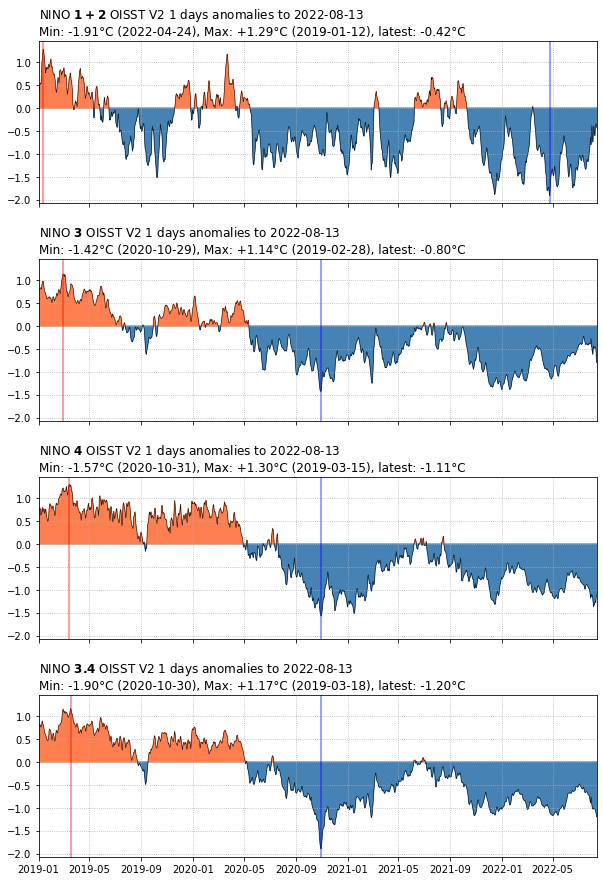

In [33]:
f, axes = plt.subplots(
    nrows=len(dset.nino.data[:-1]), figsize=(10, 15), sharex=True, sharey=True
)

plt.subplots_adjust(hspace=0.35)

for i, region in enumerate(dset.nino.data[:-1]):

    ax = axes[i]

    df = anoms_ts.loc[:, region]
        
    ax.fill_between(
        df.index, 0, df.values, df.values > 0, interpolate=True, color="coral"
    )
    ax.fill_between(
        df.index, 0, df.values, df.values <= 0, interpolate=True, color="steelblue"
    )

    ax.plot(df.index, df.values, color="k", lw=0.5)
    
    ax.grid(ls=":")

    title = title = "NINO " + r"$\bf{" + region + "}$" + f" OISST V2 {ndays_agg} days anomalies to {last_day:%Y-%m-%d}\nMin: {df.min():+4.2f}°C ({df.idxmin():%Y-%m-%d}), Max: {df.max():+4.2f}°C ({df.idxmax():%Y-%m-%d}), latest: {df.iloc[-1]:+4.2f}°C"

    ax.set_title(title, loc="left")

    ax.axhline(0, color="0.8", zorder=-1)

    ax.axvline(df.idxmin(), color="b", alpha=0.5)
    ax.axvline(df.idxmax(), color="r", alpha=0.5)

    ax.set_xlim(first_day, last_day)

In [34]:
f.savefig(
    f"/home/nicolasf/Desktop/prototype_NINO_indices_{ndays_agg}days_agg_to_{last_day:%Y%m%d}.png",
    dpi=200,
    bbox_inches="tight",
    facecolor="w",
)

In [35]:
dset.close()